[View in Colaboratory](https://colab.research.google.com/github/shin-sforzando/ctr-forecaster/blob/master/CNN.ipynb)

# CNN

## Install

In [0]:
!pip install -q tensorboardcolab
!apt-get -q -qq install -y graphviz
!pip install -q pydot

## Initialize

In [0]:
import keras
import keras.backend as K

import tensorflow as tf

config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_validate, cross_val_score, KFold, train_test_split
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from tqdm import tqdm

sns.set(color_codes=True)

In [0]:
batch_size=16
epochs=100
n_splits=4
monitor = "mean_squared_error"

from datetime import datetime, timedelta, timezone

JST = timezone(timedelta(hours=+9), "JST")
now = datetime.now(JST).strftime("%Y%m%d_%H:%M")

## Load

In [19]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Save

In [0]:
# from PIL import Image
# from pathlib import Path

# x = []
# y = []

# img_path = Path("/content/gdrive/My Drive/Colab Notebooks/dataset/images/")

# for i in tqdm(img_path.glob("*.jpg")):
#   img = Image.open(i)
#   a = keras.preprocessing.image.img_to_array(img)
#   x.append(a)
#   ctr = float(i.stem.split("_")[1])
#   y.append(ctr)

# x = np.asarray(x, dtype=np.float32)
# y = np.asarray(y, dtype=np.float32)
# x /= 255.0
# y /= 100.0

# np.save("/content/gdrive/My Drive/Colab Notebooks/dataset/x", x)
# np.save("/content/gdrive/My Drive/Colab Notebooks/dataset/y", y)

In [0]:
x = np.load("/content/gdrive/My Drive/Colab Notebooks/dataset/x.npy")
y = np.load("/content/gdrive/My Drive/Colab Notebooks/dataset/y.npy")

## Learn

### Model

In [0]:
def get_model():
  metrics=["cosine_proximity", "mean_squared_error", "mean_absolute_error"]
  
  model = keras.Sequential()
  model.add(keras.layers.SeparableConv2D(128, kernel_size=3, padding="same", data_format="channels_last", activation="relu", input_shape=(250, 300, 3)))
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.SeparableConv2D(64, kernel_size=3, strides=2, padding="same", activation="relu"))
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.SeparableConv2D(32, kernel_size=3, strides=2, padding="same", activation="relu"))
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.SeparableConv2D(16, kernel_size=3, strides=2, padding="same", activation="relu"))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(1, activation="sigmoid"))

  model.compile(loss="mean_squared_error", optimizer="adam", metrics=metrics)
  
  return model

### Input Data

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### Callback

In [0]:
callbacks = []

#### CSVLogger

In [0]:
csvLogger = keras.callbacks.CSVLogger(now + ".csv", separator=",", append=True)
callbacks.append(csvLogger)

#### EarlyStopping

In [0]:
earlyStopping = keras.callbacks.EarlyStopping(monitor=monitor, patience=2, verbose=1)
callbacks.append(earlyStopping)

#### Hyperdash

In [27]:
!pip install -q hyperdash
!hyperdash signup --github
#%env HYPERDASH_API_KEY=xD8dhpcTm0zRRLGu5oPf+/fKIskU54QDBwEoZLXCkUg=

env: HYPERDASH_API_KEY=xD8dhpcTm0zRRLGu5oPf+/fKIskU54QDBwEoZLXCkUg=


In [28]:
from keras.callbacks import Callback
from hyperdash import Experiment

class Hyperdash(Callback):
  def __init__(self, entries, exp):
    super(Hyperdash, self).__init__()
    self.entries = entries
    self.exp = exp

  def on_epoch_end(self, epoch, logs=None):
    for entrie in self.entries:
      log = logs.get(entrie)
      if log is not None:
        self.exp.metric(entrie, log)

exp = Experiment("CNN " + now, capture_io=False)
hyperdash = Hyperdash([monitor], exp=exp)
callbacks.append(hyperdash)

Error from Hyperdash server: invalid_api_key


#### LearningRateScheduler

In [0]:
# base_lr = 1e-3
# lr_decay_rate = 1 / 3
# lr_steps = 4
# learningRateScheduler = keras.callbacks.LearningRateScheduler(lambda ep: float(base_lr * lr_decay_rate ** (ep * lr_steps // epochs)), verbose=1)
# callbacks.append(learningRateScheduler)

#### ModelCheckPoint

In [0]:
hdf5_path = now + "_{epoch:02d}-{loss:.3f}.hdf5"
modelCheckPoint = keras.callbacks.ModelCheckpoint(hdf5_path, monitor=monitor, verbose=1, save_best_only=True, save_weights_only=False, period=1)
callbacks.append(modelCheckPoint)

#### ReduceLROnPlateau

In [0]:
reduceLROnPlateau = keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=10, verbose=1, cooldown=0, min_lr=0)
callbacks.append(reduceLROnPlateau)

#### TensorBoardColab

In [32]:
tensorBoardColab = TensorBoardColab(startup_waiting_time=10)
tensorBoardColabCallback = TensorBoardColabCallback(tensorBoardColab)
callbacks.append(tensorBoardColabCallback)

Wait for 10 seconds...
TensorBoard link:
http://b6eee77c.ngrok.io


### Fitting w/ KerasRegressor

In [33]:
scoring = "neg_mean_squared_error"

from keras.wrappers.scikit_learn import KerasRegressor

try:
  estimator = KerasRegressor(build_fn=get_model, batch_size=batch_size, epochs=epochs)
  kfold = KFold(n_splits=n_splits, shuffle=True)
  # results = cross_validate(estimator, x_train, y_train, cv=kfold, fit_params={"callbacks": callbacks}, scoring=["neg_mean_squared_error"], return_train_score=True, verbose=1)
  results = cross_val_score(estimator, x_train, y_train, cv=kfold, fit_params={"callbacks": callbacks}, scoring=scoring, verbose=1)
except KeyboardInterrupt:
  pass
finally:
  exp.end()

Epoch 1/100
1179/1179 [==============================] - 24s 20ms/step - loss: 9.2521e-05 - cosine_proximity: -0.9746 - mean_squared_error: 9.2521e-05 - mean_absolute_error: 0.0045
| mean_squared_error:   0.000093 |

Epoch 00001: mean_squared_error improved from inf to 0.00009, saving model to 20181007_08:43_01-0.000.hdf5
Epoch 2/100
1179/1179 [==============================] - 22s 18ms/step - loss: 8.9723e-05 - cosine_proximity: -1.0000 - mean_squared_error: 8.9723e-05 - mean_absolute_error: 0.0044
| mean_squared_error:   0.000090 |

Epoch 00002: mean_squared_error improved from 0.00009 to 0.00009, saving model to 20181007_08:43_02-0.000.hdf5
Epoch 3/100
1179/1179 [==============================] - 21s 18ms/step - loss: 8.8709e-05 - cosine_proximity: -1.0000 - mean_squared_error: 8.8709e-05 - mean_absolute_error: 0.0044
| mean_squared_error:   0.000089 |

Epoch 00003: mean_squared_error improved from 0.00009 to 0.00009, saving model to 20181007_08:43_03-0.000.hdf5
Epoch 4/100
1179/117

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  8.9min finished


This run of CNN 20181007_08:43 ran for 0:09:20 and logs are available locally at: /root/.hyperdash/logs/cnn-20181007-08-43/cnn-20181007-08-43_2018-10-06t23-44-20-903453.log


In [34]:
# for key, value in results.items():
#   print("{:<30}: {:>8.3f} ± {:.3f}".format(key, value.mean(), value.std()))

print(results)
print("{}: {:.9f}".format(scoring, results.mean()))

[-1.11205620e-04 -7.98233232e-05 -7.46256192e-05 -1.14566574e-04]
neg_mean_squared_error: -0.000095055


In [35]:
model = get_model()

for k, v in zip(model.metrics_names, model.evaluate(x_test, y_test)):
  print("{:<20}: {:>20}".format(k, v))

394/394 [==============================] - 2s 6ms/step
loss                : 0.00011377145165170077
cosine_proximity    :  -0.5465964134877104
mean_squared_error  : 0.00011377145165170077
mean_absolute_error : 0.004595862749992364


## Visualize

### Model

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_19 (Separab (None, 250, 300, 128)     539       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 125, 150, 128)     0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 125, 150, 128)     0         
_________________________________________________________________
separable_conv2d_20 (Separab (None, 63, 75, 64)        9408      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 31, 37, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 31, 37, 64)        0         
_________________________________________________________________
separable_conv2d_21 (Separab (None, 16, 19, 32)        2656      
__________

In [0]:
import pydot
keras.utils.vis_utils.plot_model(model, to_file="/content/gdrive/My Drive/Colab Notebooks/fig/model_cnn.png", show_shapes=True, show_layer_names=True)

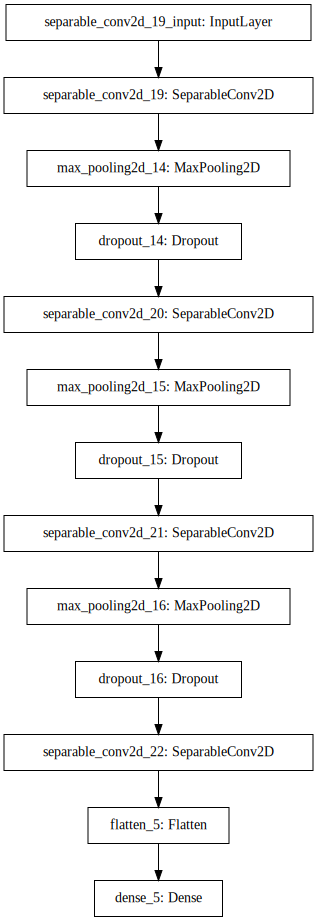

In [38]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Check

Saving 000000018093.jpg to 000000018093.jpg
uploaded file: 000000018093.jpg (45.7646484375 kB)
1/1 [==============================] - 0s 254ms/step
predict: [[0.00663689]]


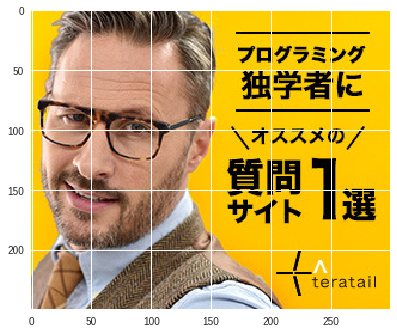

In [39]:
from google.colab import files

uploaded = files.upload()

for f in uploaded.keys():
  print("uploaded file: {name} ({length} kB)".format(name=f, length=len(uploaded[f]) / 1024))
  check_image = keras.preprocessing.image.load_img(f, target_size=(250, 300))
  check_array = keras.preprocessing.image.img_to_array(check_image)
  check_array = np.expand_dims(check_array, axis=0)
  check_array /= 255.0
  result = model.predict(check_array, verbose=1)
  print("predict:", result * 100)
  plt.imshow(check_image)